In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, exposure, morphology
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [5]:
xray = io.imread('Image.png', as_gray=True)
xray

array([[0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]], dtype=uint8)

In [7]:
better_xray = exposure.equalize_adapthist(xray)
better_xray

array([[0.0032961 , 0.0032961 , 0.0032961 , ..., 0.01300128, 0.01300128,
        0.01300128],
       [0.0032961 , 0.0032961 , 0.0032961 , ..., 0.01294024, 0.01300128,
        0.01300128],
       [0.0032961 , 0.0032961 , 0.0032961 , ..., 0.01300128, 0.01300128,
        0.01300128],
       ...,
       [0.02380516, 0.02380516, 0.02380516, ..., 0.02313374, 0.02313374,
        0.02313374],
       [0.02380516, 0.02380516, 0.02380516, ..., 0.02313374, 0.02313374,
        0.02313374],
       [0.02380516, 0.02380516, 0.02380516, ..., 0.02313374, 0.02313374,
        0.02313374]])

In [11]:
my_threshold = filters.threshold_otsu(better_xray)
lung_vs_not_lung = better_xray > my_threshold
lung_vs_not_lung

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [15]:
cleaned_binary = morphology.remove_small_objects(lung_vs_not_lung, min_size=100)
cleaned_binary = morphology.binary_closing(cleaned_binary, morphology.disk(3))
cleaned_binary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [17]:
my_lung_mask = ~cleaned_binary  
lung_only = better_xray * my_lung_mask
lung_only

array([[0.0032961 , 0.0032961 , 0.0032961 , ..., 0.01300128, 0.01300128,
        0.01300128],
       [0.0032961 , 0.0032961 , 0.0032961 , ..., 0.01294024, 0.01300128,
        0.01300128],
       [0.0032961 , 0.0032961 , 0.0032961 , ..., 0.01300128, 0.01300128,
        0.01300128],
       ...,
       [0.02380516, 0.02380516, 0.02380516, ..., 0.02313374, 0.02313374,
        0.02313374],
       [0.02380516, 0.02380516, 0.02380516, ..., 0.02313374, 0.02313374,
        0.02313374],
       [0.02380516, 0.02380516, 0.02380516, ..., 0.02313374, 0.02313374,
        0.02313374]])

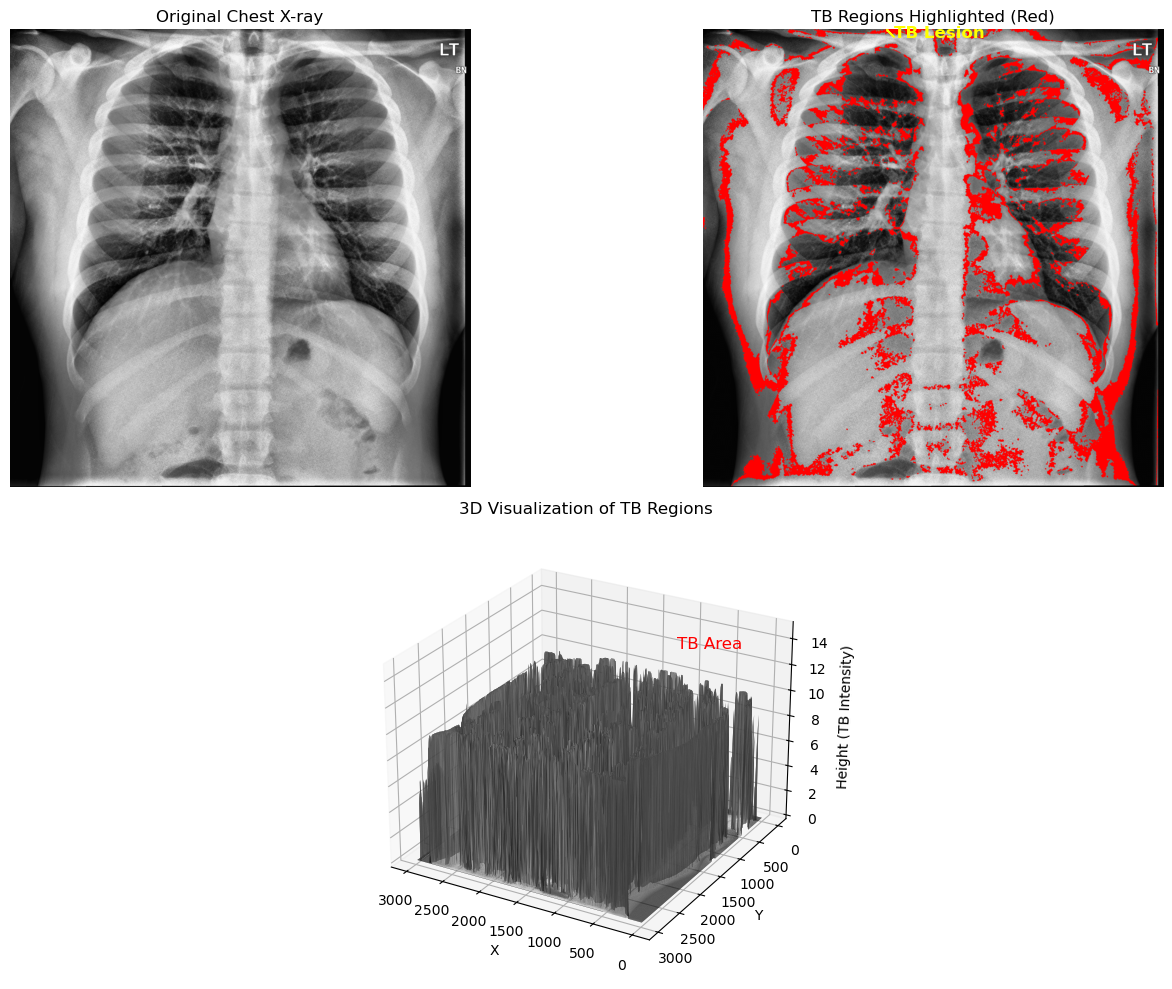

In [23]:
lung_pixels = lung_only[my_lung_mask].reshape(-1, 1)
if lung_pixels.size > 0:
    kmeans_model = KMeans(n_clusters=3, random_state=42).fit(lung_pixels)
    cluster_image = np.zeros_like(lung_only)
    cluster_image[my_lung_mask] = kmeans_model.labels_ + 1 
    avg_brightness = []
    for i in range(3):
        avg_brightness.append(np.mean(lung_pixels[kmeans_model.labels_ == i]))
    tb_cluster_num = np.argmax(avg_brightness) + 1
    tb_areas = cluster_image == tb_cluster_num
    tb_areas = morphology.remove_small_objects(tb_areas, min_size=50)
    tb_areas = morphology.binary_closing(tb_areas, morphology.disk(2))
    height_values = np.zeros_like(xray, dtype=float)
    height_values[tb_areas] = 1.0
    smooth_height = filters.gaussian(height_values, sigma=3)
    y_coords, x_coords = np.mgrid[0:xray.shape[0], 0:xray.shape[1]]
    fig = plt.figure(figsize=(14, 10))
    subplot1 = fig.add_subplot(221)
    subplot1.imshow(xray, cmap='gray')
    subplot1.set_title('Original Chest X-ray')
    subplot1.axis('off')
    subplot2 = fig.add_subplot(222)
    color_overlay = np.zeros((*xray.shape, 3))
    norm_xray = xray.copy()
    if norm_xray.max() > 1.0:
        norm_xray = norm_xray / 255.0
    color_overlay[:,:,0] = norm_xray  
    color_overlay[:,:,1] = norm_xray  
    color_overlay[:,:,2] = norm_xray  
    
    color_overlay[tb_areas, 0] = 1.0  
    color_overlay[tb_areas, 1] = 0.0  
    color_overlay[tb_areas, 2] = 0.0 
    color_overlay = np.clip(color_overlay, 0, 1)
    
    subplot2.imshow(color_overlay)
    subplot2.set_title('TB Regions Highlighted (Red)')
    subplot2.axis('off')
    from matplotlib.patches import Arrow
    biggest_tb_point = np.unravel_index(np.argmax(smooth_height), smooth_height.shape)
    tb_y, tb_x = biggest_tb_point
    arrow_x_start = tb_x + 50 if tb_x + 50 < xray.shape[1] else tb_x - 50
    arrow_y_start = tb_y + 50 if tb_y + 50 < xray.shape[0] else tb_y - 50
    my_arrow = Arrow(arrow_x_start, arrow_y_start, 
                     tb_x-arrow_x_start, tb_y-arrow_y_start, 
                     width=20, color='yellow')
    subplot2.add_patch(my_arrow)
    subplot2.text(arrow_x_start, arrow_y_start, "TB Lesion", 
                  color='yellow', fontsize=12, fontweight='bold')
    subplot3 = fig.add_subplot(212, projection='3d')
    my_stride = 5
    surface = subplot3.plot_surface(
        x_coords[::my_stride, ::my_stride], 
        y_coords[::my_stride, ::my_stride], 
        smooth_height[::my_stride, ::my_stride] * 10,  # Exaggerate height
        facecolors=plt.cm.gray(better_xray[::my_stride, ::my_stride]),
        rstride=1, cstride=1, 
        linewidth=0, antialiased=True, shade=True
    )
    subplot3.view_init(elev=25, azim=120)
    subplot3.set_zlim(0, 15)
    subplot3.set_title('3D Visualization of TB Regions')
    subplot3.set_xlabel('X')
    subplot3.set_ylabel('Y')
    subplot3.set_zlabel('Height (TB Intensity)')
    subplot3.text(tb_x, tb_y, 12, "TB Area", color='red', fontsize=12)
    plt.tight_layout()
    plt.savefig('my_tb_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Hmm, couldn't detect the lungs in this image. Maybe try another X-ray?")